In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [2]:
interactionfile = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_dscript_r6e6_predictions_0.05thresh.txt'
DSDfile = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_dscript_r6e6_predictions_0.05thresh.cDSD_converged.mtx.DSD1'
# interactionfile = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/candidate_pairs_hvul_hydra_mwt100_asof_20200624_50_800.out.positive'
# DSDfile = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/20200624_50_800_hvulg_cDSD_converged_t0.7.DSD1'
edge_weight_thresh = 0.05

In [3]:
df = pd.read_csv(DSDfile,sep='\t',index_col=0,header=0)
protein_names = [str(i) for i in df.index]
DSD = df.values

In [4]:
len(protein_names)

7010

In [5]:
# with open(DSDfile,'r') as f:
#     protein_names = [str(i) for i in f.readline().strip().split()]

In [6]:
fullG = nx.read_weighted_edgelist(interactionfile)
print('Selecting DSD Connected Component...')
G = fullG.subgraph(protein_names)
print('Filtering Edges with Confidence Threshold {}...'.format(edge_weight_thresh))
wG = nx.Graph()
for (u,v,d) in G.edges.data():
    if d['weight'] >= edge_weight_thresh:
        wG.add_edge(u,v,weight=d['weight'])
del G
G = wG
A = nx.to_numpy_matrix(G, nodelist=protein_names)
degrees = [i[1] for i in list(G.degree())]

print('-'*12)
print('Nodes: {}\nEdges: {}'.format(len(G.nodes), len(G.edges)))
print('Median Degree: {}\nAverage Degree: {}'.format(np.median(degrees), np.mean(degrees)))
print('Sparsity: {}'.format(len(G.edges()) / len(G)**2))
print('-'*12)

Selecting DSD Connected Component...
Filtering Edges with Confidence Threshold 0.05...
------------
Nodes: 7010
Edges: 70200
Median Degree: 9.0
Average Degree: 20.028530670470754
Sparsity: 0.0014285685214315803
------------


In [35]:
# N_HUBS = 1
# hubs = sorted(set(G.degree()),key=lambda x: x[1], reverse=True)
# for i in range(N_HUBS):
#     print(hubs[i][0], hubs[i][1], prot_go_db.loc[hubs[i][0],:].pfam_list, prot_go_db.loc[hubs[i][0],:].GO_list)

In [36]:
#bet_cen = nx.betweenness_centrality(G)

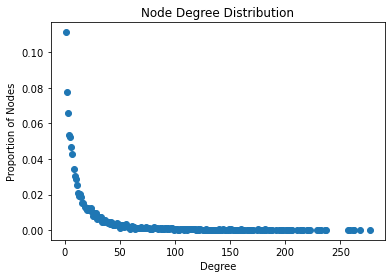

In [7]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i,0)
    degreeDist[i] = n + 1

plt.xlabel('Degree')
plt.ylabel('Proportion of Nodes')  # we already handled the x-label with ax1
plt.title('Node Degree Distribution')
plt.scatter(degreeDist.keys(), [i/len(G) for i in degreeDist.values()])
#plt.savefig('/afs/csail/u/s/samsl/db/Coral/Pdam/degree_distribution.png')
plt.show()

In [38]:
def RBF(D, sigma=None):
    """
    Convert distance matrix D into similarity matrix S using Radial Basis Function (RBF) Kernel
    RBF(x,x') = exp( -((x - x')**2 / 2sigma**@))
    """
    sigma = sigma or np.sqrt(np.max(D))
    return np.exp(-1 * (np.square(D) / (2 * sigma**2))) 

In [39]:
simDSD = RBF(DSD)

In [41]:
simDSD

array([[1.        , 0.99375136, 0.99387216, ..., 0.87774864, 0.82677026,
        0.82677026],
       [0.99375136, 1.        , 0.99089675, ..., 0.87537138, 0.82360647,
        0.82360647],
       [0.99387216, 0.99089675, 1.        , ..., 0.87985622, 0.82944274,
        0.82944274],
       ...,
       [0.87774864, 0.87537138, 0.87985622, ..., 1.        , 0.8751029 ,
        0.8751029 ],
       [0.82677026, 0.82360647, 0.82944274, ..., 0.8751029 , 1.        ,
        0.99912635],
       [0.82677026, 0.82360647, 0.82944274, ..., 0.8751029 , 0.99912635,
        1.        ]])

In [42]:
from sklearn.cluster import SpectralClustering
K = 500
RANDOM_STATE = 42
SC = SpectralClustering(n_clusters=K, assign_labels="discretize", random_state=RANDOM_STATE, affinity='precomputed')

In [43]:
SC.fit(simDSD)

SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=500, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=42)

In [44]:
with open(DSDfile+'.sc_labels.txt','w+') as f:
    f.write(','.join([str(i) for i in SC.labels_]))
with open(DSDfile+'.sc_labels.txt','r') as f:
    sclabels = np.array([int(i) for i in f.readline().strip().split(',')])

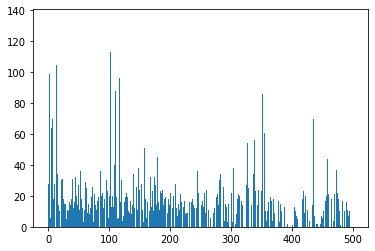

In [45]:
plt.hist(SC.labels_,bins=np.arange(K+1))
plt.show()

In [1365]:
#pos=nx.spring_layout(G)
# import json
# #pos = {k: list(v) for k,v in pos.items()}
# with open('/afs/csail/u/s/samsl/db/Coral/Pdam/pdam_network_spring_layout','w+') as f:
#     f.write(json.dumps(pos))

KeyboardInterrupt: 

In [152]:
pos = json.load(open('/afs/csail/u/s/samsl/db/Coral/Pdam/pdam_network_spring_layout'))
pos = {k: np.array(v) for k,v in pos.items()}

In [46]:
clusts = [[j for j in range(len(SC.labels_)) if SC.labels_[j] == i] for i in range(max(SC.labels_)+1)]

In [47]:
filteredClusts = [i for i in clusts if len(i) >= 3]

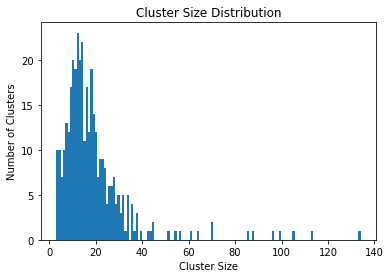

In [48]:
sizes = [len(i) for i in filteredClusts]
# sizes = [len(i) for i in clusters]
plt.hist(sizes,bins=max(sizes))
plt.xlabel('Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Cluster Size Distribution')
#plt.savefig('/afs/csail/u/s/samsl/db/Coral/Pdam/cluster_size_distribution.png')
plt.show()

In [8]:
import json
import hashlib
import collections

class Cluster:
    def __init__(self,proteins):
        self.proteins = proteins
    
    def __len__(self):
        return len(self.proteins)
    
    def __repr__(self):
        reprStr = "Cluster of {} [{},{},...] (hash {})".format(len(self), self.proteins[0], self.proteins[1], hash(self))
        if hasattr(self, 'G'):
            reprStr += "\nTriangles: {}\nMax Degree: {}".format(self.triangles(), max(self.G.degree(), key=lambda x: x[1])[1])
        if hasattr(self, 'GO_terms'):
            reprStr += "\nTop Terms:\n\t{}".format('\n\t'.join(
                    ['{} ({})'.format(i[0], i[1]) for i in self.get_top_terms(5)]
            ))
        return reprStr
    
    def __hash__(self):
        return int(hashlib.md5(''.join(self.proteins).encode()).hexdigest(), 16)
    
    def to_dict(self):
        D = {}
        D['id'] = hash(self)
        D['proteins'] = []
        for p in self.proteins:
            pD = {}
            pD['name'] = p
            if hasattr(self, 'GO_DB'):
                pD['go'] = list(self.GO_DB[self.GO_DB['string'] == p]['GO_ids'])
            D['proteins'].append(pD)
        D['go'] = sorted([{"id": i.ID, "desc": i.name, "freq": self.GO_terms[i]} for i in self.GO_terms], key = lambda x: x['freq'], reverse=True)
        if not hasattr(self,'G'):
            pass
        else:
            D['graph'] = list(self.G.edges())
        return D
    
    def to_json(self):
        return json.dumps(self.to_dict())
    
    def add_GO_terms(self, go_db):
        self.GO_terms = {}
        self.GO_DB = go_db
        for prot in self.proteins:
            goIds = list(go_db[go_db['string'] == prot]['GO_ids'])
            #goIds = go_db.loc[prot,'GO_ids']
            if len(goIds) == 0:
                continue
            for gid in goIds:
                try:
                    goObj = GO_OBJECTS[gid]
                except KeyError:
                    GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gid})
                    goObj = GO_OBJECTS[gid]
                goCount = self.GO_terms.setdefault(goObj,0)
                self.GO_terms[goObj] = goCount + 1
    
    def get_proteins_by_GO(self, GO_id):
        return [p for p in self.proteins if GO_id in prot_go_db.loc[p,'GO_ids']]
    
    def get_GO_by_protein(self, protein):
        assert protein in self.proteins, "{} not in cluster".format(protein)
        return [gt for gt in coi.GO_terms if gt.ID in prot_go_db.loc[protein,'GO_ids']]
    
    def get_top_terms(self,N):
        if not hasattr(self, 'GO_terms'):
            raise NotImplementedError("GO Terms have not been added yet.")
        GOlist = list(self.GO_terms.keys())
        if N == -1:
            N = len(GOlist)
        sortedList = sorted(GOlist,key=lambda x: self.GO_terms[x],reverse=True)[:N]
        return list(zip(sortedList, [self.GO_terms[i] for i in sortedList]))
    
    def set_graph(self,G):
        self.G = G.subgraph(self.proteins)
    
    def triangles(self):
        return sum([i for i in nx.triangles(self.G).values()]) / 3
    
    def draw_degree_histogram(self,draw_graph=True):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        if draw_graph:
            plt.axes([0.4, 0.4, 0.5, 0.5])
            pos = nx.spring_layout(G, k=0.15,iterations=10)
            plt.axis('off')
            nx.draw_networkx_nodes(G, pos, node_size=20)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
        plt.show()
    
    def draw_graph(self):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        nx.draw_kamada_kawai(G, with_labels=True,node_size=600, font_size=8)
    
def cluster_from_json(jsonString):
        clust = Cluster([])
        D = json.loads(jsonString)
        clust.proteins = [i['name'] for i in D['proteins']]
        clust.GO_terms = {}
        for goDict in D['go']:
            gid = goDict['id']
            gdesc = goDict['desc']
            try:
                goObj = GO_OBJECTS[gid]
            except KeyError:
                GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gdesc})
                goObj = GO_OBJECTS[gid]
            clust.GO_terms[goObj] = goDict['freq']
        try:
            edgeList = D['graph']
            G = nx.Graph()
            for e in edgeList:
                G.add_edge(*e)
            clust.G = G
        except KeyError:
            pass
        return clust
        
class GO:
    def __init__(self, ID, features):
        self.ID = ID
        self.D = features
        self.name = features['name']
        
    def __repr__(self):
        return '{} - <{}>'.format(self.ID, self.name)
    
    def __eq__(self, other):
        return self.ID == other.ID
    
    def __hash__(self):
        return hash(self.ID)

def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None

def readClusters(infile,sep=','):
    clusts = []
    with open(infile,'r') as f:
        for line in f:
            clusts.append(Cluster(line.strip().split(sep)))
    return clusts

def read_GO_obo(infile):
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tDict[line[0]] = ''.join(line[1:])
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = v.strip()
                    tDict[k] = v
                terms[tDict['id']] = GO(tDict['id'], tDict)
    return terms

def writeClusters(outfile, clusts):
    with open(outfile,'w+') as f:
        for cl in clusts:
            f.write('{}\n'.format(','.join([str(i) for i in cl])))
            
def GO_search(clusters, GO_term, N=20):
    if isinstance(GO_term,str):
        GO_term = GO_OBJECTS[GO_term]
    return [c for c in clusters if GO_term in [i[0] for i in c.get_top_terms(N)]]

def protein_search(clusters, protein_list):
    if isinstance(protein_list, str):
        protein_list = [protein_list]
    plist = [c for c in clusters if np.array([p in c.proteins for p in protein_list]).all()]
    if len(plist) == 0:
        return None
    elif len(plist) == 1:
        return plist[0]
    else:
        return plist

In [9]:
#clustsNames = [[protein_names[i] for i in cl] for cl in filteredClusts]
#writeClusters(DSDfile+'.clusters.csv', clustsNames)

NameError: name 'filteredClusts' is not defined

In [10]:
def read_GO_obo_2(infile):
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tList = tDict.setdefault(line[0],[])
                    tList.append(''.join(line[1:]))
                    tDict[line[0]] = tList
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = [i.strip() for i in v]
                    tDict[k] = v
                terms[tDict['id'][0]] = GO(tDict['id'][0], tDict)
    return terms

In [11]:
go_obj = read_GO_obo_2("/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/go-basic.obo")

In [12]:
class GO_Tree_Root:
    def __init__(self, go_obj):
        self.children = []
        self.go_trees = {}
        self.go_obj = go_obj
        self.parents = []
    
    def __repr__(self):
        return 'Root: {}'.format(self.children)
    
    def get_is_a(self, t):
        try:
            t_is_a = [i.split('!')[0].strip() for i in t.D['is_a']]
        except:
            t_is_a = []
        return t_is_a
    
    def get_name(self,t):
        return self.go_obj[t].D['name']
    
    def add_term(self, t):
        t_is_a = self.get_is_a(t)
        self.go_trees[t.ID] = GO_Tree(t.ID)
        for anc in t_is_a:
            ancTree = self.go_trees.setdefault(anc, GO_Tree(anc))
            ancTree.add_descendant(t.ID)
            self.go_trees[t.ID].parents.append(anc)
        if len(t_is_a) == 0:
            self.children.append(t)
            
    def path_to_root(self,t):
        path = []
        path.append((t,self.get_name(t)))
        for i in self.go_trees[t].parents:
            path.append(self.path_to_root(i))
        return path

    def path_between(self, a, b, many=False):
        path = []
        for i in self.go_trees[a].parents:
            if i == b:
                return [(i,self.get_name(i))]
            else:
                l = self.path_between(i,b)
                if len(l) > 0:
                    path.append((a,self.get_name(a)))
                    path.append(l)
                    if not many:
                        return path
        return path
    
    def exists_path(self, a, b):
        return len(self.path_between(a,b)) > 0
    
class GO_Tree:
    def __init__(self, term):
        self.ID = term
        self.parents = []
        self.children = []
        
    def __repr__(self):
        return '{}: {}'.format(self.ID, self.children)
        
    def add_descendant(self, t):
        self.children.append(t)

In [13]:
gtr = GO_Tree_Root(go_obj)

In [14]:
for t in tqdm(go_obj.values()):
    gtr.add_term(t)

In [15]:
gtr.go_trees['GO:0061824']

GO:0061824: []

In [16]:
gtr.exists_path('GO:0000022','GO:0009987')

True

In [17]:
gtr.path_to_root('GO:0000022')

[('GO:0000022', ['mitotic spindle elongation']),
 [('GO:0051231', ['spindle elongation']),
  [('GO:0007017', ['microtubule-based process']),
   [('GO:0009987', ['cellular process']),
    [('GO:0008150', ['biological_process'])]]],
  [('GO:0022402', ['cell cycle process']),
   [('GO:0009987', ['cellular process']),
    [('GO:0008150', ['biological_process'])]]]],
 [('GO:1903047', ['mitotic cell cycle process']),
  [('GO:0022402', ['cell cycle process']),
   [('GO:0009987', ['cellular process']),
    [('GO:0008150', ['biological_process'])]]]]]

In [18]:
go_slim = read_GO_obo_2("/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/goslim_drosophila.obo")

In [19]:
paths = {}

for gt in tqdm(go_obj):
    for gs in go_slim:
        p = paths.setdefault(gt, [])
        pb = gtr.path_between(gt,gs)
        if len(pb) > 0:
            p.append(pb)
        paths[gt] = p

In [20]:
gtr.path_to_root('GO:0007155')

[('GO:0007155', ['cell adhesion']),
 [('GO:0009987', ['cellular process']),
  [('GO:0008150', ['biological_process'])]],
 [('GO:0022610', ['biological adhesion']),
  [('GO:0008150', ['biological_process'])]]]

In [21]:
GO_OBJECTS = read_GO_obo("/afs/csail.mit.edu/u/s/samsl/db/pfam_go/go.obo")

In [22]:
clusters = readClusters(DSDfile+'.clusters.csv')
#clusters = readClusters('/afs/csail/u/s/samsl/db/STRING/h.vulgaris/20200624_50_800_hvulg_cDSD_converged_t0.7_spectralClusterFile_k500.csv')

In [23]:
#prot_go_db = pd.read_csv("/scratch2/rsingh/work/corals/data/processed/proteins_list_mwt100_asof_20200617.csv")
# prot_go_db['GO_str'] = prot_go_db['GO_list']
# prot_go_db['GO_list'] = prot_go_db['GO_str'].str.split(';')
# def extract_GO_id_from_list(l):
#     if isinstance(l,list):
#         return [i.split('|')[0] for i in l]
#     else:
#         return None
# prot_go_db['GO_ids'] = prot_go_db['GO_list'].apply(extract_GO_id_from_list)
# prot_go_db = prot_go_db.set_index('pdam_id')
# prot_go_db['species_id'] = prot_go_db['species_id'].astype(str)
# prot_go_db = prot_go_db.set_index('species_id')

In [24]:
seqDb = pd.read_csv('/afs/csail/u/s/samsl/db/STRING/d.mela/downloads/string_seq_db.csv',sep=',')
id2FB = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/FBgn_map.csv',sep=',')
FB2GO = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/FBgn_GO_map.csv',sep=' ',header=None)

In [25]:
seqDb

,protein_id,protein_name,sequence
0,3223846,FBpp0070057,MRFALATVAIIWALFVLADGVDPGNFKTCEQSSFCRRSRKIQGSGS...
1,3223846,FBpp0070058,MRFALATVAIIWALFVLADGVDPGNFKTCEQSSFCRRSRKIQGSGS...
2,3223846,FBpp0070059,MRFALATVAIIWALFVLADGVDPGNFKTCEQSSFCRRSRKIQGSGS...
3,3223846,FBpp0070060,MRFALATVAIIWALFVLADGVDPGNFKTCEQSSFCRRSRKIQGSGS...
4,3223846,FBpp0070061,MRFALATVAIIWALFVLADGVDPGNFKTCEQSSFCRRSRKIQGSGS...
...,...,...,...
26940,3234482,FBpp0288495,MSLASRTSVKSGGSEVDLRQRNASIRNLFAPSSAELAKKKEARQRS...
26941,3234482,FBpp0288496,MSLASRTSVKSGGSEVDLRQRNASIRNLFAPSSAELAKKKEARQRS...
26942,3234483,FBpp0288498,MHMRLHLVRFMFINLLLSCCFWLYDNVAAADSQIPSRAGDSAKDAA...
26943,3234483,FBpp0288499,MHMRLHLVRFMFINLLLSCCFWLYDNVAAADSQIPSRAGDSAKDAA...


In [26]:
string2GO = pd.merge(pd.merge(id2FB,FB2GO,left_on='protein_name',right_on=0,how='inner'), seqDb, left_on='protein_id', right_on='protein_id',how='inner')[['protein_name_y',1]]
string2GO.columns = ['string','GO_ids']
string2GO['string'] = string2GO['string'].apply(lambda x: '7227.'+x)
#string2GO.set_index('string')

In [27]:
string2GO.drop_duplicates(['GO_ids'])

,string,GO_ids
0,7227.FBpp0071677,GO:0048749
3,7227.FBpp0071677,GO:0016324
6,7227.FBpp0071677,GO:0005912
9,7227.FBpp0071677,GO:0003674
12,7227.FBpp0082828,GO:0005634
...,...,...
231702,7227.FBpp0088281,GO:0050710
231770,7227.FBpp0077447,GO:0097370
232138,7227.FBpp0080452,GO:0042692
232358,7227.FBpp0080452,GO:0031033


In [28]:
stringGO_DB = {}
for _, i in tqdm(string2GO.iterrows(),total=len(string2GO)):
    l = stringGO_DB.setdefault(i.string,[])
    l.append(i.GO_ids)
    stringGO_DB[i.string] = l

In [29]:
def get_is_a(go_term):
    try:
        t_is_a = [i.split('!')[0].strip() for i in go_term.D['is_a']]
    except:
        t_is_a = []
    return t_is_a

def map_up(go_id, go_objects, goslim_objects):
    t_is_a = get_is_a(go_objects[go_id])
    slim_terms = []
    for i in t_is_a:
        if i in goslim_objects.keys():
            slim_terms.append(i)
        slim_terms.extend(map_up(i,go_objects, goslim_objects))
    return slim_terms

In [30]:
import seaborn as sns
DSDfileDscript = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_dscript_r6e6_predictions_0.05thresh.cDSD_converged.mtx.DSD1'
DSDfilePipr = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_pipr_predictions_all.positive.0.5thresh.cDSDconverged.mtx.DSD1'
DSDfileDscriptF3 = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_f3e7_predictions.0.5thresh.mtx.DSD1'
DSDfileRandom = '/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/dmela_10M_candidates_20201018_100k_random.mtx.DSD1'

clustersD = readClusters(DSDfileDscript+'.clusters.csv')
clustersP = readClusters(DSDfilePipr+'.clusters.csv')
clustersD3 = readClusters(DSDfileDscriptF3+'.clusters.csv')
clustersR = readClusters(DSDfileRandom+'.clusters.csv')

def jaccard(s1, s2):
    if len(s1.union(s2)) == 0: return 1
    return (len(s1.intersection(s2)) / len(s1.union(s2)))

def getClusterSimilarities(clusters):
    maxes = []
    means = []
    medians = []
    nums_found = []
    
    for c in clusters:
        clustSlim = []
        for p in c.proteins:
            pSlim = []
            try:
                for i in stringGO_DB[p]:
                    #print(i)
                    #pSlim.append(i)
                    pSlim.extend(map_up(i,go_obj, go_slim))
            except KeyError:
                pass
            #print(len(set(pSlim)), pSlim)
            nums_found.append(len(set(pSlim)))
            clustSlim.append((p,pSlim))
            
        sims = []
        for i, il in clustSlim:
            for j, jl in clustSlim[1:]:
                s = jaccard(set(il), set(jl))
#                 s = 0
#                 for k0 in set(il):
#                     for k1 in set(jl):
#                         if k0 == k1:
#                             s += 1
                sims.append(s)

        maxes.append(np.max(sims))
        means.append(np.mean(sims))
        medians.append(np.median(sims))
#     plt.hist(nums_found,bins=np.arange(0,15))
#     plt.show()
    print(len(maxes), len(means), len(medians))
    return (maxes, means, medians)

pmax, pmean, pmed = getClusterSimilarities(clustersP)
dmax, dmean, dmed = getClusterSimilarities(clustersD)
d3max, d3mean, d3med = getClusterSimilarities(clustersD3)
rmax, rmean, rmed = getClusterSimilarities(clustersR)

384 384 384
374 374 374
432 432 432
435 435 435


In [31]:
from scipy.stats import ttest_ind
def one_tail_ttest(null, greater):
    tstat, p = ttest_ind(null, greater)
    if tstat > 0:
        return tstat, (1-(p/2))
    else:
        return tstat, p/2

In [32]:
q = np.quantile(pmean + dmean, 0.90)
#q= 0.5
print(q)
c_p = len(np.array(pmean)[np.array(pmean) >= q])
c_d =len(np.array(dmean)[np.array(dmean) >= q])
print(c_p, c_d, 100 * (c_d-c_p)/c_p)

0.4681359492949722
34 42 23.529411764705884


In [33]:
len(np.array(d3mean)[np.array(d3mean) >= q])

52

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


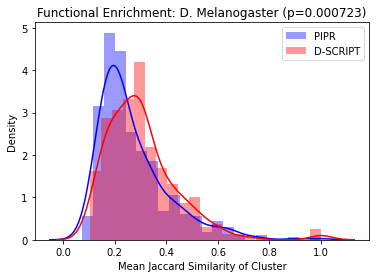

In [35]:
sns.set_palette('colorblind')
kde = True
sns.distplot( pmean , color="blue", label="PIPR", kde=kde)
sns.distplot( dmean , color="red", label="D-SCRIPT", kde=kde)
#sns.distplot( d3mean, color="orange", label="D-SCRIPT F3")
#sns.distplot( rmean , color="gray", label="Random")
tstat, p = one_tail_ttest(pmean, dmean)
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.xlabel('Mean Jaccard Similarity of Cluster')
plt.ylabel('Density')
plt.legend()
#plt.savefig('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/jaccard_distplot.svg')
plt.show()

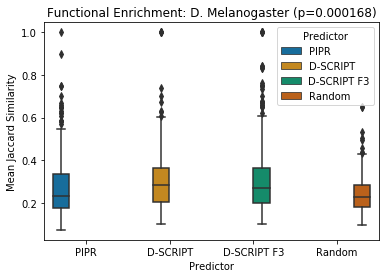

In [114]:
df_mean = pd.DataFrame({'Predictor':['PIPR']*len(pmean)+['D-SCRIPT']*len(dmean)+['D-SCRIPT F3']*len(d3mean)+['Random']*len(rmean), 'Jaccard':np.concatenate((pmean,dmean,d3mean,rmean))})
tstat, p = one_tail_ttest(pmean, dmean)
sns.boxplot(data=df_mean, x='Predictor', y='Jaccard', hue='Predictor')
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.ylabel('Mean Jaccard Similarity')
plt.show()

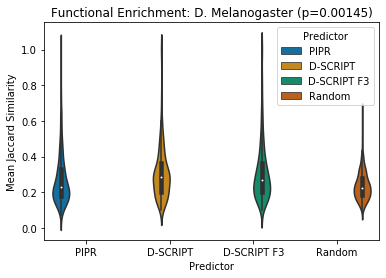

In [130]:
tstat, p = ttest_ind(pmean, dmean)
sns.violinplot(data=df_mean, x='Predictor', y='Jaccard', hue='Predictor', scale='area',inner='box')
tstat, p = one_tail_ttest(pmean, dmean)
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.ylabel('Mean Jaccard Similarity')
plt.show()

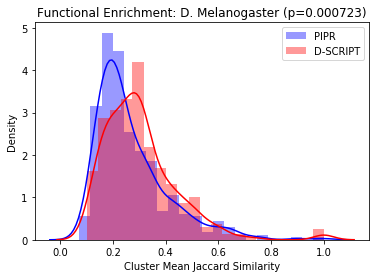

In [315]:
sns.set_palette('colorblind')
sns.distplot( df_mean[df_mean["Predictor"] == 'PIPR']['Jaccard'] , color="blue", label="PIPR")
sns.distplot( df_mean[df_mean["Predictor"] == 'D-SCRIPT']['Jaccard'] , color="red", label="D-SCRIPT")
#sns.distplot( df_mean[df_mean["Predictor"] == 'D-SCRIPT F3']['Jaccard'] , color="orange", label="D-SCRIPT 3")
#sns.distplot( df_mean[df_mean["Predictor"] == 'Random']['Jaccard'] , color="gray", label="Random")
tstat, p = one_tail_ttest(pmean, dmean)
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.xlabel('Cluster Mean Jaccard Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

In [58]:
def get_dsd_dist(p0,p1):
    return df.loc[p0,p1]
get_dsd_dist(df.index[0],df.index[1])

5.355978008057361

In [41]:
def get_protein_slimterms(p):
    pSlim = []
    try:
        for i in stringGO_DB[p]:
            #print(i)
            #pSlim.append(i)
            pSlim.extend(map_up(i,go_obj, go_slim))
    except KeyError:
        pass
    return pSlim

In [55]:
def get_jaccard_slim(p0,p1):
    set0 = get_protein_slimterms(p0)
    set1 = get_protein_slimterms(p1)
    return jaccard(set(set0), set(set1))

In [69]:
from tqdm import tqdm

In [71]:
prot_dists = []
dscript_jaccard = []

from itertools import combinations
for (p0,p1) in tqdm(combinations(df.index, r=2),total=(len(df.index) ** 2)/2):
    prot_dists.append(get_dsd_dist(p0,p1))
    dscript_jaccard.append(get_jaccard_slim(p0,p1))

100%|█████████▉| 24566545/24570050.0 [3:52:12<00:01, 1763.27it/s]  


In [94]:
from scipy.stats import pearsonr, spearmanr

In [116]:
pearsonr(1/np.array(prot_dists), np.array(dscript_jaccard))

(0.11986872854449347, 0.0)

In [115]:
spearmanr(1/np.array(prot_dists), np.array(dscript_jaccard))

SpearmanrResult(correlation=0.12305466218754063, pvalue=0.0)

In [77]:
pipr_df = pd.read_csv(DSDfilePipr,sep='\t',index_col=0,header=0)

In [79]:
def get_dsd_dist_pipr(p0,p1):
    return pipr_df.loc[p0,p1]

In [83]:
pipr_dists = []
pipr_jaccard = []
for (p0,p1) in tqdm(combinations(pipr_df.index, r=2),total=(len(pipr_df.index) ** 2)/2):
    pipr_dists.append(get_dsd_dist_pipr(p0,p1))
    pipr_jaccard.append(get_jaccard_slim(p0,p1))

100%|█████████▉| 20253430/20256612.5 [3:07:13<00:01, 1802.95it/s]  


In [108]:
len(pipr_dists), len(prot_dists)

(20253430, 24566545)

In [113]:
pearsonr(1/np.array(pipr_dists), np.array(pipr_jaccard))

(0.0042806659682207236, 1.062481639856987e-82)

In [114]:
spearmanr(1/np.array(pipr_dists), np.array(pipr_jaccard))

SpearmanrResult(correlation=0.005186232141755453, pvalue=1.7341105990715795e-120)

In [105]:
np.savez("distance_jaccard_correlation.npz",dscript_distance=prot_dists,dscript_jaccard=dscript_jaccard,pipr_distance=pipr_dists,pipr_jaccard=pipr_jaccard)

In [544]:
with open('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/STRING_GO_map.gogo.in','w+') as f:
    for k,v in stringGO_DB.items():
        f.write('{} {}\n'.format(k,' '.join(v)))

In [154]:
GOGO = {}
with open('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/STRING_GO_map.gogo.out','r') as f:
    for line in tqdm(f,total=227601780):
        l = line.strip().split()
        pr_l = GOGO.setdefault(l[0],{})
        pr_l[l[1]] = l[3]
        GOGO[l[0]] = pr_l

In [194]:
def getClusterGOGOSimilarities(clusters):
    maxes = []
    means = []
    medians = []
    nums_found = []
    sims = []
    
    for c in tqdm(clusters):
        passes = 0
        clustSims = []
        for p1 in c.proteins:
            for p2 in c.proteins:
                if p1 != p2:
                    try:
                        x = GOGO[p1][p2]
                        if x == 'NA':
                            x = 0
                        else:
                            x = float(x)
                        clustSims.append(x)
                    except KeyError:
                        passes += 1
                        pass

        if len(clustSims) == 0:
            maxes.append(0)
            means.append(0)
            medians.append(0)
        else:
            maxes.append(np.max(clustSims))
            means.append(np.mean(clustSims))
            medians.append(np.median(clustSims))
    print(len(maxes), len(means), len(medians))
    return (maxes, means, medians)


384 384 384



374 374 374


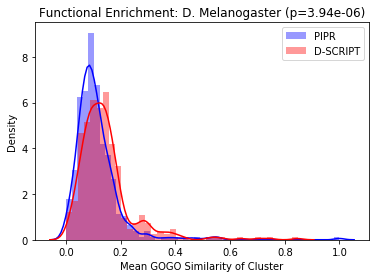

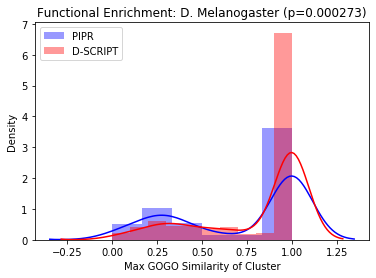

In [316]:
pmaxGOGO, pmeanGOGO, pmedGOGO = getClusterGOGOSimilarities(clustersP)
dmaxGOGO, dmeanGOGO, dmedGOGO = getClusterGOGOSimilarities(clustersD)
sns.set_palette('colorblind')
kde = True
sns.distplot( pmeanGOGO , color="blue", label="PIPR", kde=kde)
sns.distplot( dmeanGOGO , color="red", label="D-SCRIPT", kde=kde)
#sns.distplot( d3mean, color="orange", label="D-SCRIPT F3")
#sns.distplot( rmean , color="gray", label="Random")
tstat, p = one_tail_ttest(pmeanGOGO, dmeanGOGO)
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.xlabel('Mean GOGO Similarity of Cluster')
plt.ylabel('Density')
plt.legend()
plt.savefig('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/gogo_distplot.svg')
plt.show()
sns.distplot( pmaxGOGO , color="blue", label="PIPR", kde=kde)
sns.distplot( dmaxGOGO , color="red", label="D-SCRIPT", kde=kde)
#sns.distplot( d3mean, color="orange", label="D-SCRIPT F3")
#sns.distplot( rmean , color="gray", label="Random")
tstat, p = one_tail_ttest(pmaxGOGO, dmaxGOGO)
plt.title('Functional Enrichment: D. Melanogaster (p={:.3})'.format(p))
plt.xlabel('Max GOGO Similarity of Cluster')
plt.ylabel('Density')
plt.legend()
plt.savefig('/afs/csail.mit.edu/u/s/samsl/db/STRING/d.mela/functional_genomics/gogo_max_distplot.svg')
plt.show()

5.355978008057361

In [263]:
for clust in tqdm(clusters):
    clust.add_GO_terms(string2GO)

In [264]:
for i in tqdm(clusters):
    i.set_graph(G)

In [265]:
clusters.sort(key=lambda x: len(x), reverse=True)

In [266]:
pk.dump(clusters, open(DSDfile+'.clusters_GO.pk','wb'))
#pk.dump(clusters, open('/afs/csail/u/s/samsl/db/STRING/h.vulgaris/50_800_cDSD_converged_t0.7_spectral500_GOclusters.pk','wb'))

In [267]:
clusters = pk.load(open(DSDfile+'.clusters_GO.pk','rb'))
# vulg_clust = pk.load(open('/afs/csail/u/s/samsl/db/STRING/h.vulgaris/50_800_cDSD_converged_t0.7_spectral500_GOclusters.pk','rb'))

In [ ]:
# # Split Largest PDam Cluster
# degrees = []
# for i in clusters[0].G.degree():
#     degrees.append(i)
# degrees.sort(key=lambda x: x[1],reverse=True)

In [13]:
# subCl1graph = nx.ego_graph(clusters[0].G,'pdam_00012487-RA')
# subCl2graph = nx.ego_graph(clusters[0].G,'pdam_00002621-RA')
# cl1 = Cluster(list(subCl1graph.nodes))
# cl2 = Cluster(list(subCl2graph.nodes))
# cl1.add_GO_terms(prot_go_db)
# cl1.set_graph(G)
# cl2.add_GO_terms(prot_go_db)
# cl2.set_graph(G)
# del clusters[0]
# clusters.append(cl1)
# clusters.append(cl2)
# clusters.sort(key=lambda x: len(x), reverse=True)

In [268]:
clusters[0:5]

[Cluster of 134 [7227.FBpp0291082,7227.FBpp0291081,...] (hash 1127301862646460282)
 Triangles: 162.0
 Max Degree: 22
 Top Terms:
 	GO:0005739 - <mitochondrion> (94)
 	GO:0005829 - <cytosol> (47)
 	GO:0006096 - <glycolytic process> (31)
 	GO:0042593 - <glucose homeostasis> (18)
 	GO:0004332 - <fructose-bisphosphate aldolase activity> (14),
 Cluster of 113 [7227.FBpp0111531,7227.FBpp0303089,...] (hash 823421542299629204)
 Triangles: 97.0
 Max Degree: 18
 Top Terms:
 	GO:0005887 - <integral component of plasma membrane> (135)
 	GO:0007186 - <G protein-coupled receptor signaling pathway> (48)
 	GO:0004930 - <G protein-coupled receptor activity> (44)
 	GO:0004989 - <octopamine receptor activity> (40)
 	GO:0007218 - <neuropeptide signaling pathway> (36),
 Cluster of 105 [7227.FBpp0302796,7227.FBpp0080297,...] (hash 1660132682631322655)
 Triangles: 24.0
 Max Degree: 19
 Top Terms:
 	GO:0005739 - <mitochondrion> (18)
 	GO:0005829 - <cytosol> (16)
 	GO:0005737 - <cytoplasm> (14)
 	GO:0004022 - 

In [269]:
len(clusters)

374

Cluster of 27 [7227.FBpp0080227,7227.FBpp0111638,...] (hash 1893344987987480843)
Triangles: 0.0
Max Degree: 26
Top Terms:
	GO:0005634 - <nucleus> (18)
	GO:0005515 - <protein binding> (9)
	GO:0005737 - <cytoplasm> (6)
	GO:0007259 - <receptor signaling pathway via JAK-STAT> (5)
	GO:0006357 - <regulation of transcription by RNA polymerase II> (5)


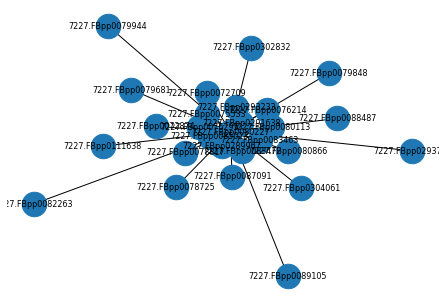

In [270]:
i = 60
coi = clusters[i]
print(coi)
coi.draw_graph()

In [271]:
clusterDict = {hash(i): i for i in clusters}

In [272]:
clustDictJson = {hash(i): i.to_json() for i in clusters}

In [273]:
with open(DSDfile+'.clusterDict.json','w+') as f:
    f.write(json.dumps(clustDictJson))

# IsoRank

In [64]:
pdam_pred_file = '/afs/csail/u/s/samsl/db/Coral/Pdam/candidate_pairs_mwt100_asof_20200617_50_800.out.positive'
hvulg_pred_file = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/candidate_pairs_hvul_hydra_mwt100_asof_20200624_50_800.out.positive'
pdam_preds = pd.read_csv(pdam_pred_file,sep='\t',header=None)
hvulg_preds = pd.read_csv(hvulg_pred_file,sep='\t',header=None)
pdam_preds = pdam_preds[pdam_preds.iloc[:,2] >= 0.7]
hvulg_preds = hvulg_preds[hvulg_preds.iloc[:,2] >= 0.7]
pdam_preds = pdam_preds.iloc[:,:2]
hvulg_preds = hvulg_preds.iloc[:,:2]
pdam_preds.columns = ['INTERACTOR_A','INTERACTOR_B']
hvulg_preds.columns = ['INTERACTOR_A','INTERACTOR_B']

In [67]:
pdam_v_pdam_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/pdam-vs-pdam.txt'
hvulg_v_hvulg_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-hvulg.txt'
hvulg_v_pdam_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-pdam.txt'
pdam_v_pdam = pd.read_csv(pdam_v_pdam_blast,sep='\t',header=None)
hvulg_v_hvulg = pd.read_csv(hvulg_v_hvulg_blast,sep='\t',header=None)
hvulg_v_pdam = pd.read_csv(hvulg_v_pdam_blast,sep='\t',header=None)
pdam_v_pdam = pdam_v_pdam.iloc[:,[0,1,11]]
hvulg_v_hvulg = hvulg_v_hvulg.iloc[:,[0,1,11]]
hvulg_v_pdam = hvulg_v_pdam.iloc[:,[0,1,11]]

In [71]:
pdam_inter_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Pdam.tab'
hvulg_inter_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg.tab'
pdam_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Pdam-Pdam.evals'
hvulg_v_hvulg_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg-Hvulg.evals'
hvulg_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg-Pdam.evals'
pdam_preds.to_csv(pdam_inter_out,sep='\t',header=True,index=False)
hvulg_preds.to_csv(hvulg_inter_out,sep='\t',header=True,index=False)
pdam_v_pdam.to_csv(pdam_v_pdam_out,sep='\t',header=False,index=False)
hvulg_v_hvulg.to_csv(hvulg_v_hvulg_out,sep='\t',header=False,index=False)
hvulg_v_pdam.to_csv(hvulg_v_pdam_out,sep='\t',header=False,index=False)

In [461]:
pdam_prots = set(pdam_preds.INTERACTOR_A).union(set(pdam_preds.INTERACTOR_B))
hvulg_prots = set(hvulg_preds.INTERACTOR_A).union(set(hvulg_preds.INTERACTOR_B))

In [462]:
pdam_graph_file = '/afs/csail/u/s/samsl/db/Coral/Pdam/candidate_pairs_mwt100_asof_20200617_50_800.out.positive'
hvulg_graph_file = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/candidate_pairs_hvul_hydra_mwt100_asof_20200624_50_800.out.positive'

In [477]:
edge_weight_thresh = 0.7
pdamG = nx.read_weighted_edgelist(pdam_pred_file)
hvulgG = nx.read_weighted_edgelist(hvulg_pred_file)

In [471]:
mappings = {}
with open('/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg_pdam_isorank_match-score.txt', 'r') as f:
    for line in f:
        l = line.strip().split()
        src = str(l[0])
        dest = str(l[1])
        score = float(l[2])
        oldScore = mappings.setdefault(src, (dest,score))[1]
        if score > oldScore:
            mappings[src] = (dest,score)

In [472]:
len(mappings.keys())

10221

In [1122]:
hydra_sc_pdam_ids = ['pdam_00001652-RA',
                    'pdam_00001769-RA',
                    'pdam_00002536-RA',
                    'pdam_00003493-RA',
                    'pdam_00003898-RA',
                    'pdam_00004758-RA',
                    'pdam_00007071-RA',
                    'pdam_00008652-RA',
                    'pdam_00012620-RA',
                    'pdam_00013172-RA',
                    'pdam_00015399-RA',
                    'pdam_00015652-RA',
                    'pdam_00015761-RA',
                    'pdam_00016349-RA',
                    'pdam_00016805-RA',
                    'pdam_00017544-RA',
                    'pdam_00019316-RA']

In [1512]:
pdam_siebert_map_fi = '/afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/seqs/mapping_pdam_Siebert_via_hvul.csv'
siebert_human_name_map_fi = '/afs/csail.mit.edu/u/r/rsingh/work/corals/data/processed/Siebert_PMC7104783_IDs_w_names.txt'
ortholog_file = '/afs/csail.mit.edu/u/s/samsl/Berger/interactionPredictionWithContact/isorank/ortholog_mappings.csv'
with open(pdam_siebert_map_fi) as f:  num_cols = max(len(line.split(',')) for line in f);  f.seek(0);
pdam_siebert_map = pd.read_csv(pdam_siebert_map_fi,names=range(num_cols),engine='python')
siebert_human_map = pd.read_csv(seibert_human_name_map_fi,engine='python',header=None)
pdam_siebert_map = pdam_siebert_map.set_index(0)

In [1514]:
orthologs = pd.merge(pdam_siebert_map.loc[hydra_sc_pdam_ids,:].reset_index(),siebert_human_map,left_on=1,right_on=1,how='outer').loc[:,['0_x',1,'0_y']]
orthologs.columns = ['Pdam','Siebert','Human']
orthologs = orthologs.set_index('Pdam')

In [1517]:
clusters_in = []
for prt in orthologs.index:
    if isinstance(prt,str):
        x = prot_search(clusters, prt)
    else:
        x = None
    if x:
        clusters_in.append(str(hash(x)))
    else:
        clusters_in.append(None)
    #print('{} in {}'.format(prt, prot_search(clusters, prt)))
orthologs['Cluster'] = clusters_in
orthologs.to_csv(ortholog_file)

In [1516]:
orthologs

,Siebert,Human,Cluster
Pdam,,,
pdam_00001652-RA,t37156,NaN,None
pdam_00001769-RA,t30134,NaN,322269466687533872
pdam_00002536-RA,t27909,NaN,254438315280822055
pdam_00003493-RA,t22218,NaN,None
pdam_00003898-RA,t31033,NaN,94198090151503387
pdam_00004758-RA,t16456,NaN,None
pdam_00007071-RA,t22116,ETV1,None
pdam_00008652-RA,t21810,NDF1,None
pdam_00012620-RA,t2758,DAN_domain–containing_gene,None


Cluster of 17 [pdam_00016900-RA,pdam_00007315-RA,...] (hash 2224493386795527397)
Top Terms:
	GO:0004181 - <metallocarboxypeptidase activity> (9)
	GO:0005044 - <scavenger receptor activity> (6)
	GO:0034446 - <substrate adhesion-dependent cell spreading> (6)
	GO:0007371 - <ventral midline determination> (5)
	GO:0003140 - <determination of left/right asymmetry in lateral mesoderm> (5)


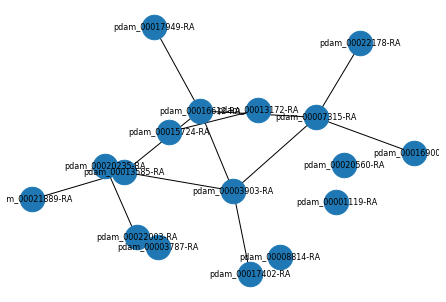

In [1523]:
coi = clusterDict[2224493386795527397]
#coi = clusterDict[1104175528426704620]
#coi = clusterDict[1981825815004671496]
print(coi)
coi.draw_graph()

In [1536]:
true_human_edge_file = "/afs/csail.mit.edu/u/s/samsl/db/STRING/homo.sapiens/binding/binding.all.pos.txt"
human_network = pd.read_csv(true_human_edge_file,sep='\t',header=None)
human_network.columns = ['INTERACTOR_A','INTERACTOR_B']
human_inter_out = "/afs/csail.mit.edu/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi.tab"
human_network['INTERACTOR_A'] = human_network['INTERACTOR_A'].str.replace('.','_')
human_network['INTERACTOR_B'] = human_network['INTERACTOR_B'].str.replace('.','_')
human_network.to_csv(human_inter_out,sep='\t',header=True,index=False)

In [1537]:
hvulg_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-hsapi.txt'
pdam_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/pdam-vs-hsapi.txt'
hsapi_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hsapi-vs-hsapi.txt'
hvulg_v_hsapi = pd.read_csv(hvulg_v_hsapi_blast,sep='\t',header=None)
pdam_v_hsapi = pd.read_csv(pdam_v_hsapi_blast,sep='\t',header=None)
hsapi_v_hsapi = pd.read_csv(hsapi_v_hsapi_blast,sep='\t',header=None)
hvulg_v_hsapi = hvulg_v_hsapi.iloc[:,[1,0,11]]
pdam_v_hsapi = pdam_v_hsapi.iloc[:,[1,0,11]]
hsapi_v_hsapi = hsapi_v_hsapi.iloc[:,[0,1,11]]

In [1538]:
hvulg_v_hsapi[1] = hvulg_v_hsapi[1].str.replace('.','_')
pdam_v_hsapi[1] = pdam_v_hsapi[1].str.replace('.','_')
hsapi_v_hsapi[1] = hsapi_v_hsapi[1].str.replace('.','_')
hsapi_v_hsapi[0] = hsapi_v_hsapi[0].str.replace('.','_')

In [1539]:
hsapi_v_hvulg_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Hvulg.evals'
hsapi_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Pdam.evals'
hsapi_v_hsapi_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Hsapi.evals'
hvulg_v_hsapi.to_csv(hsapi_v_hvulg_out,sep='\t',header=False,index=False)
pdam_v_hsapi.to_csv(hsapi_v_pdam_out,sep='\t',header=False,index=False)
hsapi_v_hsapi.to_csv(hsapi_v_hsapi_out,sep='\t',header=False,index=False)

In [1571]:
import torch

In [1599]:
def sigmoid(x,x0=0,k=1):
    return 1 / (1 + torch.exp(-k * (x - x0)))

In [1612]:
assert (sigmoid(x)>=0).all() and (sigmoid(x)<=1).all()

# Stupid Coral Tables

In [1310]:
csv_file = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_dcp.csv'
clean_csv_file = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_clean_dcp.csv'
fasta_file = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_dcp.fa'
blast_file = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_dcp_pdam_blast.csv'
blast_evalue = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_dcp_pdam_blast_significant.csv'
cluster_hits = '/afs/csail/u/s/samsl/db/Coral/Pacuta/4week_dcp_pdam_clusters.txt'

In [1311]:
f = open(csv_file,'r')

In [1312]:
header = [i.strip() for i in f.readline().strip().split(',')]

In [1313]:
lines = [[i.strip() for i in l.strip().split(',')] for l in f]

In [1314]:
f.close()

In [1315]:
def join_lines(x,y):
    assert len(x) == len(y), (x,y)
    return [x[i]+y[i] for i in range(len(x))]

In [1316]:
lines_new = []
for line in lines:
    if line.count('') > 1:
        lines_new[-1] = join_lines(lines_new[-1], line)
    else:
        lines_new.append(line)

In [1317]:
all_lines = [header] + lines_new

In [1318]:
all_lines_string = [','.join(i) for i in all_lines]

In [1319]:
with open(clean_csv_file,'w+') as f:
    for line in all_lines_string:
        f.write(line)
        f.write('\n')

In [1320]:
seqs = pd.read_csv(clean_csv_file,header=0)
nam = list(seqs['Spot(s)'].str.cat(seqs['Protein'],sep='_'))
nam = ['_'.join(n.split()) for n in nam]
seq = list(seqs['Sequence'])

In [1321]:
with open(fasta_file,'w+') as f:
    for n,s in zip(nam, seq):
        f.write('>{}\n{}\n'.format(n, s))

In [1322]:
eval_thresh = 1e-5
blastout = pd.read_csv(blast_file,header=None)
blastout.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
blastout = blastout[blastout['evalue'] < eval_thresh]
blastout.to_csv(blast_evalue,header=True,index=False)

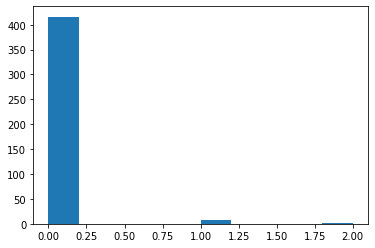

In [1323]:
hits = set(blastout['sseqid'])
n_in_clusts = []
for c in clusters:
    inclust = np.array([p in c.proteins for p in set(hits)])
    n_in_clusts.append(inclust.sum())
plt.hist(n_in_clusts)
plt.show()

In [1393]:
with open(cluster_hits,'w+') as fi:
    for h in hits:
        print('{} ({}) in {}'.format(h, ','.join(set(blastout.loc[blastout['sseqid'] == h,'qseqid'])), prot_search(clusters,h)))
        fi.write('{} ({}) in {}\n'.format(h, ','.join(set(blastout.loc[blastout['sseqid'] == h,'qseqid'])), prot_search(clusters,h)))

pdam_00019851-RA (C4-host_actine,C4-host_actin_(different_from_previous_paralog)) in Cluster of 65 [pdam_00015460-RA,pdam_00022200-RA,...] (hash 953730153325185879)
Top Terms:
	GO:0005524 - <ATP binding> (19)
	GO:0046872 - <metal ion binding> (13)
	GO:0051287 - <NAD binding> (9)
	GO:0000287 - <magnesium ion binding> (8)
	GO:0008270 - <zinc ion binding> (7)
pdam_00019358-RA (C4-host_actine,C4-host_actin_(different_from_previous_paralog)) in Cluster of 59 [pdam_00013964-RA,pdam_00025381-RA,...] (hash 1362663253743270569)
Top Terms:
	GO:0005524 - <ATP binding> (20)
	GO:0000287 - <magnesium ion binding> (12)
	GO:0046872 - <metal ion binding> (10)
	GO:0030170 - <pyridoxal phosphate binding> (9)
	GO:0042803 - <protein homodimerization activity> (9)
pdam_00022186-RA (C1-host_pentraxin) in Cluster of 45 [pdam_00022186-RA,pdam_00014342-RA,...] (hash 1557525076039568397)
Top Terms:
	GO:0005509 - <calcium ion binding> (11)
	GO:0005524 - <ATP binding> (11)
	GO:0045087 - <innate immune response> (9

Hits in Cluster: 2
set()
Cluster of 59 [pdam_00013964-RA,pdam_00025381-RA,...] (hash 1362663253743270569)
Top Terms:
	GO:0005524 - <ATP binding> (20)
	GO:0000287 - <magnesium ion binding> (12)
	GO:0046872 - <metal ion binding> (10)
	GO:0030170 - <pyridoxal phosphate binding> (9)
	GO:0042803 - <protein homodimerization activity> (9)


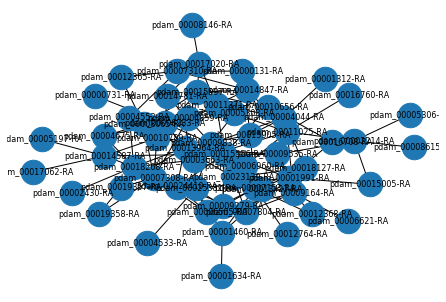

In [1325]:
print('Hits in Cluster: {}\n{}'.format(np.max(np.array(n_in_clusts)),set(hits).intersection(set(coi.proteins))))
coi = clusters[np.argmax(np.array(n_in_clusts))]
print(coi)
coi.draw_graph()

In [1095]:
poi = 'pdam_00021626-RA'

In [1096]:
prot_go_db.loc[poi,:].GO_list

['GO:0001849|molecular_function|complement component C1q complex binding',
 'GO:0008029|molecular_function|pentraxin receptor activity',
 'GO:0006953|biological_process|acute-phase response',
 'GO:0008228|biological_process|opsonization',
 'GO:0097756|biological_process|negative regulation of blood vessel diameter',
 'GO:0046790|molecular_function|virion binding',
 'GO:0005509|molecular_function|calcium ion binding',
 'GO:0050830|biological_process|defense response to Gram-positive bacterium',
 'GO:0050750|molecular_function|low-density lipoprotein particle receptor binding',
 'GO:0004866|molecular_function|endopeptidase inhibitor activity',
 'GO:0033265|molecular_function|choline binding',
 'GO:0044869|biological_process|negative regulation by host of viral exo-alpha-sialidase activity',
 'GO:0030169|molecular_function|low-density lipoprotein particle binding',
 'GO:0045087|biological_process|innate immune response',
 'GO:0044871|biological_process|negative regulation by host of viral

In [1097]:
coi = prot_search(clusters,poi)
coi